<a href="https://colab.research.google.com/github/ChoeTaeBin/Machine-Learnig/blob/main/airbnb_5_ipyb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<질문>  
상관계수를 구해 보았을때는 accomodates, beds, bedroom 등이 log_price와 높은 상관계수를 보였는데  
random forest, xgboost로 모델을 만들고 feature importance를 출력하였을때는 roomtype에 과하기 의존 하는 것 으로 나타났습니다.  
비슷하게 범주형 변수에서 각 카테고리별 평균 log_price의 분산을 구하고 이 값이 높을 수록 카테고리별로 log_price가 크게 다른 것이므로 상식적으로는 중요하게 사용되어야 하는 데 그렇지 않았습니다. 왜 이런 문제가 일어나는 것이고 어떻게 해결 할 수 있을까요?  

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

그냥 ordinal encoder는 훈련과정에서 보지못한 클래스의 값이 들어오면 에러가 납니다.   
그것을 해결하기위해서 category_encoder의 LeaveOneOutEncoder를 사용해 보려고 합니다.

In [2]:
!pip install category_encoders

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 1.2 MB/s eta 0:00:00


In [3]:
pd.set_option("display.max_columns",None) #모든 columns을 보겠다고 설정함

In [4]:
org_df = pd.read_csv('/content/drive/MyDrive/Airbnb_Data.csv') #원본데이터

In [5]:
org_df

,id,log_price,property_type,room_type,amenities,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,city,description,first_review,host_has_profile_pic,host_identity_verified,host_response_rate,host_since,instant_bookable,last_review,latitude,longitude,name,neighbourhood,number_of_reviews,review_scores_rating,thumbnail_url,zipcode,bedrooms,beds
0,6901257,5.010635,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",3,1.0,Real Bed,strict,True,NYC,"Beautiful, sunlit brownstone 1-bedroom in the ...",2016-06-18,t,t,NaN,2012-03-26,f,2016-07-18,40.696524,-73.991617,Beautiful brownstone 1-bedroom,Brooklyn Heights,2,100.0,https://a0.muscache.com/im/pictures/6d7cbbf7-c...,11201,1.0,1.0
1,6304928,5.129899,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",7,1.0,Real Bed,strict,True,NYC,Enjoy travelling during your stay in Manhattan...,2017-08-05,t,f,100%,2017-06-19,t,2017-09-23,40.766115,-73.989040,Superb 3BR Apt Located Near Times Square,Hell's Kitchen,6,93.0,https://a0.muscache.com/im/pictures/348a55fe-4...,10019,3.0,3.0
2,7919400,4.976734,Apartment,Entire home/apt,"{TV,""Cable TV"",""Wireless Internet"",""Air condit...",5,1.0,Real Bed,moderate,True,NYC,The Oasis comes complete with a full backyard ...,2017-04-30,t,t,100%,2016-10-25,t,2017-09-14,40.808110,-73.943756,The Garden Oasis,Harlem,10,92.0,https://a0.muscache.com/im/pictures/6fae5362-9...,10027,1.0,3.0
3,13418779,6.620073,House,Entire home/apt,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",4,1.0,Real Bed,flexible,True,SF,This light-filled home-away-from-home is super...,NaN,t,t,NaN,2015-04-19,f,NaN,37.772004,-122.431619,Beautiful Flat in the Heart of SF!,Lower Haight,0,NaN,https://a0.muscache.com/im/pictures/72208dad-9...,94117.0,2.0,2.0
4,3808709,4.744932,Apartment,Entire home/apt,"{TV,Internet,""Wireless Internet"",""Air conditio...",2,1.0,Real Bed,moderate,True,DC,"Cool, cozy, and comfortable studio located in ...",2015-05-12,t,t,100%,2015-03-01,t,2017-01-22,38.925627,-77.034596,Great studio in midtown DC,Columbia Heights,4,40.0,NaN,20009,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74106,14549287,4.605170,Apartment,Private room,{},1,1.0,Real Bed,flexible,False,NYC,one room in bushwick apt,NaN,t,t,NaN,2013-03-24,f,NaN,40.709025,-73.939405,one room bushwick,Williamsburg,0,NaN,https://a0.muscache.com/im/pictures/55162426/6...,11206.0,1.0,1.0
74107,13281809,5.043425,Apartment,Entire home/apt,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",4,2.0,Real Bed,moderate,True,LA,"Located on the Pacific Coast Highway, this apa...",2016-08-15,t,f,100%,2016-05-03,f,2017-04-15,33.871549,-118.396053,Spacious Hermosa 2 BR on PCH,Hermosa Beach,16,93.0,https://a0.muscache.com/im/pictures/2b86560b-a...,90254,2.0,4.0
74108,18688039,5.220356,Apartment,Entire home/apt,"{TV,Internet,""Wireless Internet"",""Air conditio...",5,1.0,Real Bed,moderate,True,NYC,A modern apartment located in East Williamsbur...,2015-01-03,t,t,100%,2012-01-05,t,2017-09-10,40.706749,-73.942377,Modern 2 Bedroom Apartment in Williamsburg,Williamsburg,43,94.0,https://a0.muscache.com/im/pictures/7fbe448c-5...,11206.0,2.0,2.0
74109,17045948,5.273000,Apartment,Entire home/apt,"{TV,""Wireless Internet"",""Air conditioning"",Kit...",2,1.0,Real Bed,strict,True,NYC,"Fully renovated, designer's studio located in ...",NaN,t,f,100%,2017-09-17,t,NaN,40.738535,-74.000157,Designer's Apartment in HEART of NYC,West Village,0,NaN,https://a0.muscache.com/im/pictures/b3971b63-0...,10011,0.0,2.0


In [6]:
df = org_df.copy() #조작을 위해 복사본을 만든다.

콤마의 수를 세서 단어수를 세고 이를 num_amenityies에 저장

In [7]:
df['num_amenities'] = df['amenities'].apply(lambda x : x.count(',') + 1)

우선 제 생각에 가격과 관련없다고 생각하는 feature들을 삭제했습니다.  
저희의 상황 가정인 '우리집을 얼마에 올려야 할지 결정하고 싶은 사용자'는 알 수 가 없는 정보들 (review_scores_rating, number_of_reviews ...)등도 일단 포함 시켰습니다.  
이런 정보들이 중요하게 작용한다면 반대로 묵을 숙소를 구하는 사용자를 대상으로한 시스템도 같이제공해 주면 좋을 것 같기 때문입니다.

In [8]:
df.drop(columns = ['id', 'description', 'name', 'thumbnail_url', 'zipcode', 'amenities'], inplace = True)
df.columns

Index(['log_price', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bed_type', 'cancellation_policy', 'cleaning_fee', 'city',
       'first_review', 'host_has_profile_pic', 'host_identity_verified',
       'host_response_rate', 'host_since', 'instant_bookable', 'last_review',
       'latitude', 'longitude', 'neighbourhood', 'number_of_reviews',
       'review_scores_rating', 'bedrooms', 'beds', 'num_amenities'],
      dtype='object')

realtor.com의 도시별 주택 렌트비 중간값 추가  
(해 보았는데 결론적으로는 별로 의미가 없었습니다. 일단, 저희 데이터가 city별 가격 분산이 너무 작습니다.)

In [9]:
median_rental_rate= {
    'NYC' : 3100,
    'LA' : 2190,
    'SF' : 2930,
    'DC' : 2220,
    'Chicago' : 1610,
    'Boston' :2700
}
df['median_rental_rate'] = df['city'].map(median_rental_rate)

feature들간의 비율도 추가 해 보았습니다.  
(이것도 큰 의미가 없었습니다.)

In [10]:
df['beds/accommodates'] = df['beds'] / df['accommodates']
df['bathrooms/accommodates'] = df['bathrooms'] / df['accommodates']

neighbourhood 특성을 정리 해 보겠습니다.

In [12]:
df['neighbourhood'].value_counts()

neighbourhood
Williamsburg          2862
Bedford-Stuyvesant    2166
Bushwick              1601
Upper West Side       1396
Mid-Wilshire          1392
                      ... 
Mill Basin               1
Mt. Vernon Square        1
Chevy Chase, MD          1
Clearing                 1
Grant City               1
Name: count, Length: 619, dtype: int64

샘플 수가 적은 카테고리는 학습에 도움이 되지 않을 것이다. 100개이하의 카테고리는 NaN값으로 만들자

In [13]:
# 값이 100보다 작은 카테고리를 NaN으로 바꾸기
value_counts = df['neighbourhood'].value_counts()
categories_to_replace = value_counts[value_counts < 100].index
df.loc[df['neighbourhood'].isin(categories_to_replace), 'neighbourhood'] = None

In [14]:
df['neighbourhood'].value_counts()

neighbourhood
Williamsburg            2862
Bedford-Stuyvesant      2166
Bushwick                1601
Upper West Side         1396
Mid-Wilshire            1392
                        ... 
Altadena                 108
Duboce Triangle          108
Mount Vernon Square      104
Tribeca                  103
Southwest Waterfront     103
Name: count, Length: 160, dtype: int64

neighbourhood별 log_price를 feature로 추가 해 보았습니다.  
사실 이 과정에서 test data의 평균 까지 이용하므로 이 과정은 잘못 되었습니다. 하지만 이렇게 해서 성능이 좋아진다면 train data만을 이용해서 평균을 구하고 이값을 새로운 feature로 추가해주는 파이프라인을 만들어서 전처리 파이프라인에 넣으면 될 것 같습니다.

In [15]:
# neighbourhood에 따른 log_price의 평균 계산
neighbourhood_mean_log_price = df.groupby('neighbourhood')['log_price'].transform('mean')

# NaN인 경우에는 NaN으로 설정
neighbourhood_mean_log_price[df['neighbourhood'].isna()] = np.nan

# 새로운 특성으로 추가
df['neighbourhood_mean_log_price'] = neighbourhood_mean_log_price

데이터를 더 들여다 보기 전에 test data를 떼어 놓겠습니다.

In [16]:
from sklearn.model_selection import train_test_split

train_df,test_df = train_test_split(df, test_size=0.2, shuffle = True, random_state = 42,)

##데이터 심층 분석

숫자형 데이터 분석 - 히트맵

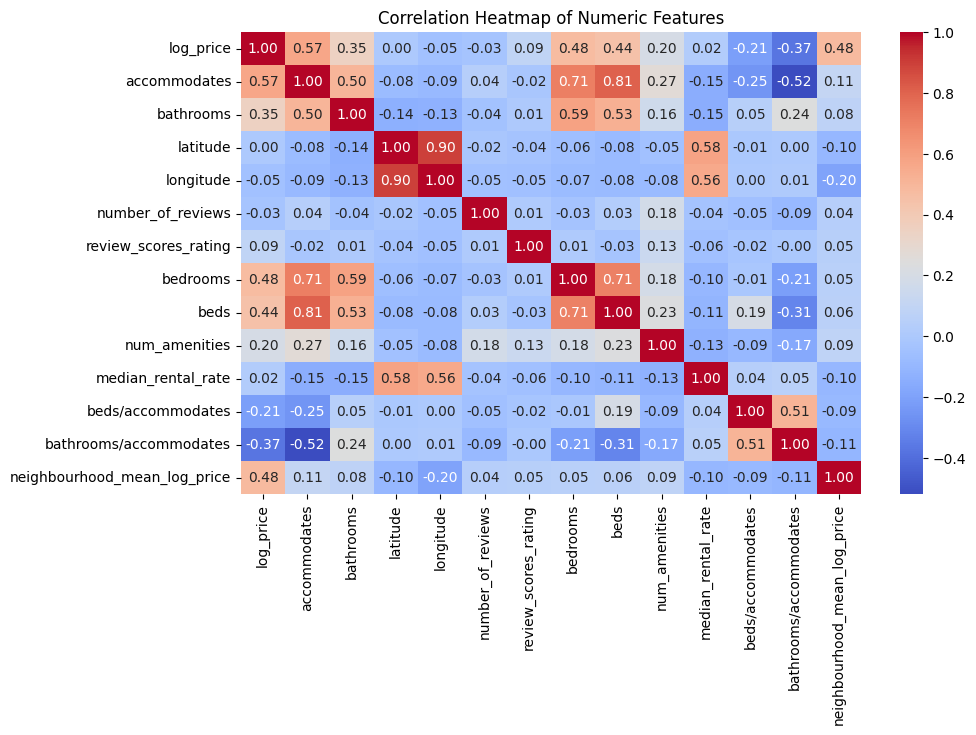

In [17]:
import seaborn as sns

# train_df에서 숫자형 열만 선택
numeric_cols = train_df.select_dtypes(include='number')

# 숫자형 열 간의 상관 관계 계산
correlation_matrix = numeric_cols.corr()

# 히트맵 생성
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Numeric Features')
plt.show()

accommodates, beds, bedsrooms가 log_price와 높은 상관계수를 보이는 것으로 나타났다.  
그리고 이 세 feature들은 서로 높은 상관계수를 보인다.

범주형 데이터 분석 - 카테고리별 log_price 평균의 분산

In [18]:
cat_f_names = train_df.columns[train_df.dtypes == 'object'] #범주형 특성 이름
var = [] #분산

for f in cat_f_names:
  temp = df.groupby(f)['log_price'].mean().var()
  var.append(temp)
  print(f, " : ", temp)

property_type  :  0.20095562774159717
room_type  :  0.43781088941061164
bed_type  :  0.042171554689177215
cancellation_policy  :  0.616759203871228
city  :  0.04179759281542942
first_review  :  0.09010605222717971
host_has_profile_pic  :  0.014662887690597785
host_identity_verified  :  0.0006834545692287833
host_response_rate  :  0.10370632425002896
host_since  :  0.07421078316988765
instant_bookable  :  0.0026054174362497664
last_review  :  0.1789463893602113
neighbourhood  :  0.13934064408170796


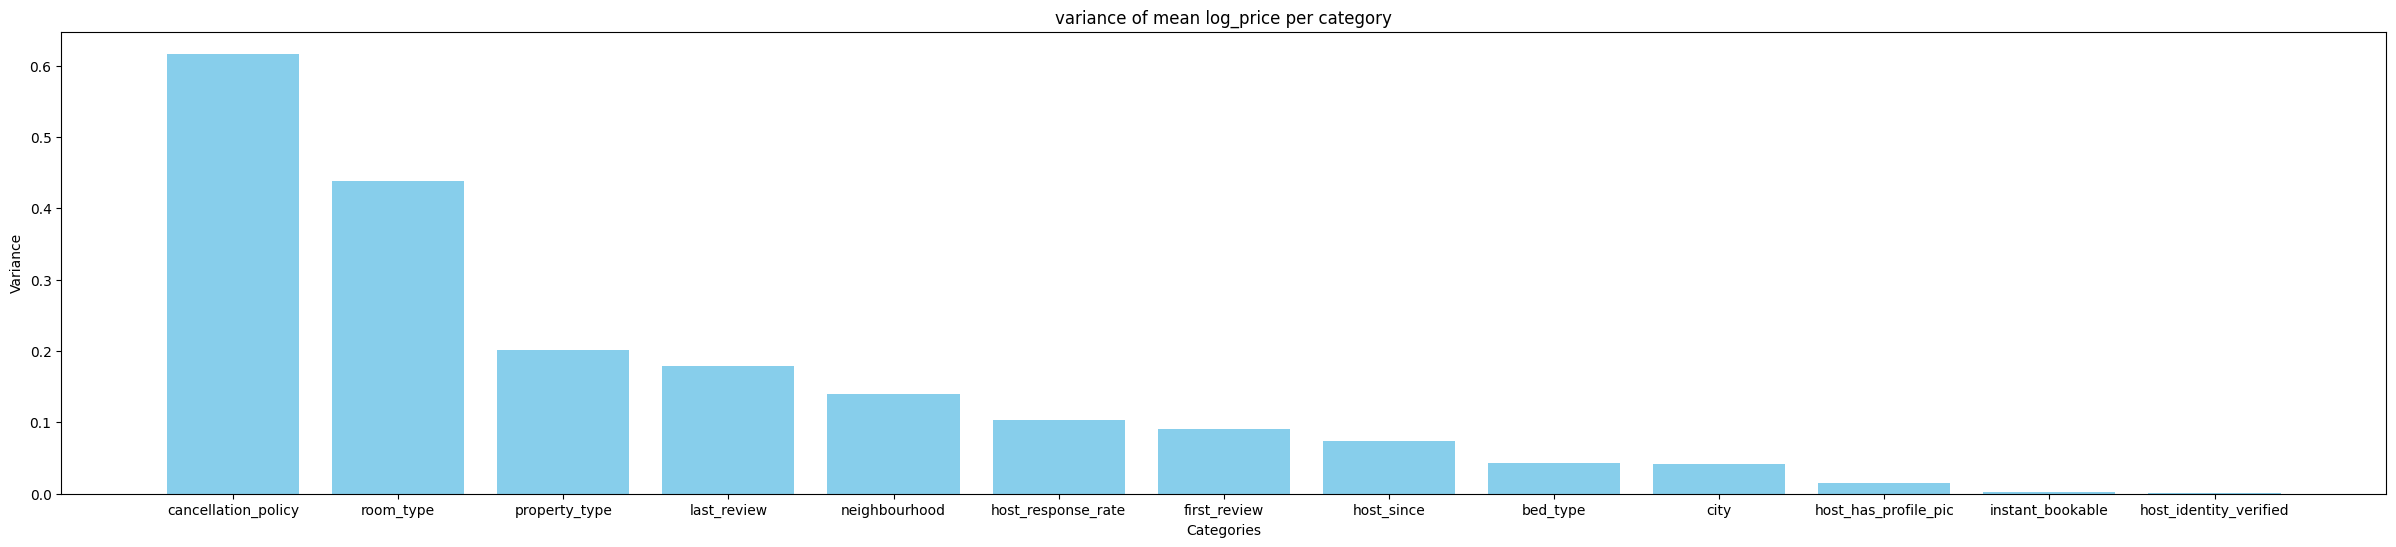

In [19]:
# y_values를 내림차순으로 정렬하고, 이에 맞춰 x_values도 정렬
sorted_indices = sorted(range(len(var)), key=lambda i: var[i], reverse=True)
sorted_x_values = [cat_f_names[i] for i in sorted_indices]
sorted_y_values = [var[i] for i in sorted_indices]

# fig 객체 생성
fig = plt.figure(figsize=(30, 6))

# ax 객체 생성
ax = fig.add_subplot(1,1,1)

# 막대 그래프 생성
ax.bar(sorted_x_values, sorted_y_values, color='skyblue')
ax.set_xlabel('Categories')
ax.set_ylabel('Variance')
ax.set_title('variance of mean log_price per category')

# 그래프 표시
plt.show()


cancellation_policy에 따라서 분산이 크게 달라지는데 이를 저희 모델이 인식하지 못하고 있습니다.

타깃 분리

In [20]:
X_train = train_df.drop(columns = ['log_price']) #log_price를 제외한 나머지
y_train = train_df['log_price'] #log_price

X_test = test_df.drop(columns = ['log_price']) #log_price를 제외한 나머지
y_test = test_df['log_price'] #log_price

전처리 파이프 라인을 만들겠습니다.

imputer(NaN값을 처리해 주는 도구)

In [21]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer

cat_imputer = make_pipeline(SimpleImputer(strategy = 'most_frequent')) #범주형은 최빈값으로 채움
num_imputer = make_pipeline(SimpleImputer(strategy = 'median')) #숫자형은 중앙값으로 채움

encoder(범주형 특성을 숫자화 해주는 도구)를 만들고 imputer와 연결해서 pipeline을 만듦

In [22]:
from sklearn.compose import ColumnTransformer
from category_encoders import LeaveOneOutEncoder

categorical_columns = X_train.columns[X_train.dtypes == 'object'] #범주형 특성 이름
numeric_columns = X_train.columns[X_train.dtypes != 'object'] #숫자형 특성 이름

cat_pipeline = Pipeline([
    ('encode', LeaveOneOutEncoder(handle_unknown='ignore')),
    ('impute', cat_imputer),
 ]) #범주형은 encoder를 추가

preprocessor = ColumnTransformer([
    ('num', num_imputer, numeric_columns),
    ('cat', cat_pipeline, categorical_columns)
]) #최종적 파이프라인

preprocessor.fit(X_train, y_train) #파이프라인을 훈련 시킴(이때 훈련 데이터로 훈련 시킴!)

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median'))]),
                                 Index(['accommodates', 'bathrooms', 'cleaning_fee', 'latitude', 'longitude',
       'number_of_reviews', 'review_scores_rating', 'bedrooms', 'beds',
       'num_amenities', 'median_rental_rate', 'beds/accommodates',
       'bathrooms/accommodates', 'neighbourhood_mean_log_pri...
                                                  LeaveOneOutEncoder(handle_unknown='ignore')),
                                                 ('impute',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent'))]))]),
                                 Index(['property_type', 'room_type', 'bed_type', 'cancellation_policy', 'city',
       'first_review', 'host_has_profile_pic', 'host_identity_verified',
       'host_response_rate', 'host_since', 'instant_bookable', 'last_review',
       'neighbourhood'],
      dtype='object'))])

데이터 전처리(파이프라인 통과시키기)

In [23]:
processed_X_train = preprocessor.transform(X_train)
processed_X_test = preprocessor.transform(X_test)

In [24]:
processed_X_train = pd.DataFrame(processed_X_train, columns = preprocessor.get_feature_names_out()) #데이터 프레임으로 만들어 주는 코드
processed_X_test = pd.DataFrame(processed_X_test, columns = preprocessor.get_feature_names_out())

random forest모델을 만들고 이를 이용해서 feature importance를 구한후 시각화

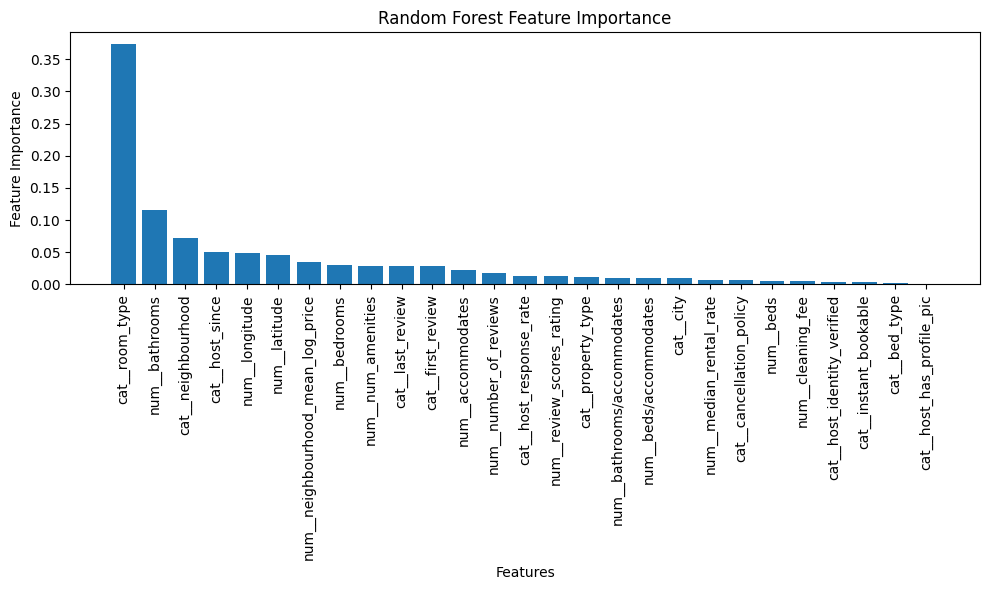

0.6921585637053778


In [25]:
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

# RandomForest 회귀 모델 생성
rf_reg_model = RandomForestRegressor()

# 모델 학습
rf_reg_model.fit(processed_X_train, y_train)

# 특성 중요도 얻기
feature_importance = rf_reg_model.feature_importances_

#특성 이름 리스트
feature_names = preprocessor.get_feature_names_out()

# 중요도가 높은 특성부터 내림차순으로 정렬합니다.
sorted_idx = feature_importance.argsort()[::-1]

# 특성 중요도를 그래프로 그립니다.
plt.figure(figsize=(10, 6))
plt.bar(range(len(feature_importance)), feature_importance[sorted_idx])
plt.xticks(range(len(feature_importance)), [feature_names[i] for i in sorted_idx], rotation=90)
plt.xlabel('Features')
plt.ylabel('Feature Importance')
plt.title('Random Forest Feature Importance')
plt.tight_layout()
plt.show()

print(r2_score(y_test, rf_reg_model.predict(processed_X_test)))

room_type에 과하게 의존하고 있습니다.

"중요도가 낮은 데이터를 더 삭제하면 점수가 높아지지 않을까?"   
라는 생각이 들어서 이를 확인 해 보기위해
중요도 순으로 데이터를 n개 선택할때 점수가 어떻게 달라지는지 분석 해 보았습니다.  
돌리는데 결과만 보시고 굉장히 시간이 많이 걸리므로 안돌리시는 게 좋을 것 같습니다.

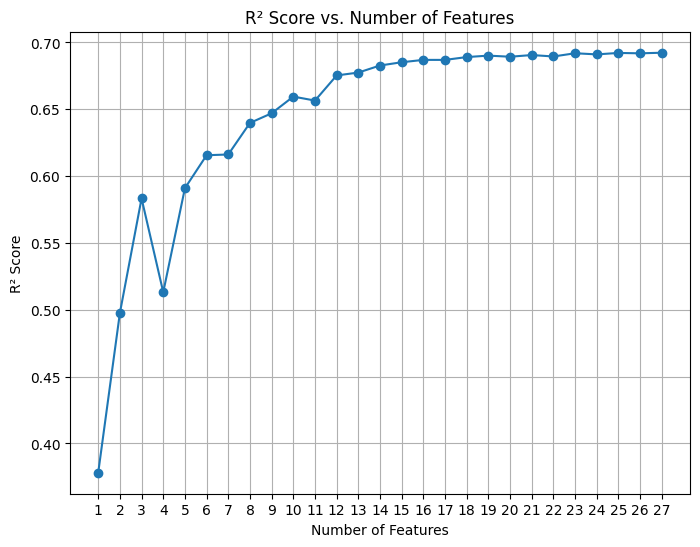

In [35]:
# n 값 리스트
n_values = np.arange(1,processed_X_train.shape[1]+1)

# 각 n 값에 대한 R² 스코어 저장
r2_scores = []

for n in n_values:
    # 상위 n개의 특성 인덱스 선택
    selected_features = sorted_idx[:n]

    # 선택된 특성으로 데이터 준비
    processed_X_train_selected = processed_X_train.iloc[:, selected_features]
    processed_X_test_selected = processed_X_test.iloc[:, selected_features]

    # RandomForest 회귀 모델 생성 및 학습
    rf_reg_model_selected = RandomForestRegressor()
    rf_reg_model_selected.fit(processed_X_train_selected, y_train)

    # 테스트 데이터로 예측 및 R² 스코어 계산
    y_pred_selected = rf_reg_model_selected.predict(processed_X_test_selected)
    r2_selected = r2_score(y_test, y_pred_selected)

    # R² 스코어 저장
    r2_scores.append(r2_selected)

# 그래프 그리기
plt.figure(figsize=(8, 6))
plt.plot(n_values, r2_scores, marker='o', linestyle='-')
plt.title('R² Score vs. Number of Features')
plt.xlabel('Number of Features')
plt.ylabel('R² Score')
plt.xticks(n_values)
plt.grid(True)
plt.show()

대부분의 데이터들이 사용될때 더 좋은 결과를 나타낸다.  
-> 지금 선택한 데이터들은 모두 어느정도 유용하게 사용 된다는 것을 알 수 있습니다.

xgboost도 이용해보았습니다.

In [37]:
import xgboost as xgb
from sklearn.metrics import r2_score, mean_squared_error

# XGBoost 회귀 모델 생성 및 학습
xgb_model = xgb.XGBRegressor()
xgb_model.fit(processed_X_train, y_train)

# 특성 중요도와 이름 출력
feature_names = preprocessor.get_feature_names_out()
importance = xgb_model.feature_importances_

sorted_indices = sorted(range(len(importance)), key=lambda i: importance[i], reverse=True)
importance = [importance[i] for i in sorted_indices]
feature_names = [feature_names[i] for i in sorted_indices]

print("Feature Importance:")
for i, (name, imp) in enumerate(zip(feature_names, importance)):
    print(f"{name}: {imp}")

# 테스트 데이터에 대한 예측 수행
y_pred = xgb_model.predict(processed_X_test)

print()

# R^2 점수 계산
r2 = r2_score(y_test, y_pred)
print("R^2 Score:", r2)

# RMSE 계산
rmse = mean_squared_error(y_test, y_pred, squared=False)
print("RMSE:", rmse)


Feature Importance:
cat__room_type: 0.5680250525474548
num__bathrooms: 0.11570373177528381
cat__neighbourhood: 0.06781382113695145
num__bedrooms: 0.047018419951200485
cat__city: 0.029463475570082664
num__accommodates: 0.02775646559894085
num__neighbourhood_mean_log_price: 0.027220051735639572
num__median_rental_rate: 0.021125730127096176
cat__last_review: 0.009369632229208946
cat__first_review: 0.009152253158390522
cat__host_since: 0.00728906225413084
num__review_scores_rating: 0.0070366146974265575
cat__host_response_rate: 0.0063894568011164665
num__longitude: 0.006361473351716995
num__latitude: 0.005320020020008087
cat__property_type: 0.005215247627347708
num__number_of_reviews: 0.005159297026693821
num__cleaning_fee: 0.0047887032851576805
num__beds/accommodates: 0.0038769340608268976
num__bathrooms/accommodates: 0.003736177459359169
num__num_amenities: 0.0037179479841142893
cat__instant_bookable: 0.0034730760380625725
cat__bed_type: 0.0034313625656068325
cat__host_has_profile_pic: 0

조금은 점수가 나아졌습니다.

cat boost를 이용해보고 SHAP 값을 계산하여 보겠습니다.

In [38]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 3.1 MB/s eta 0:00:00


In [39]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.5/540.5 kB 3.0 MB/s eta 0:00:00


R2 Score: 0.7008015718905618
RMSE: 0.3920535439480211


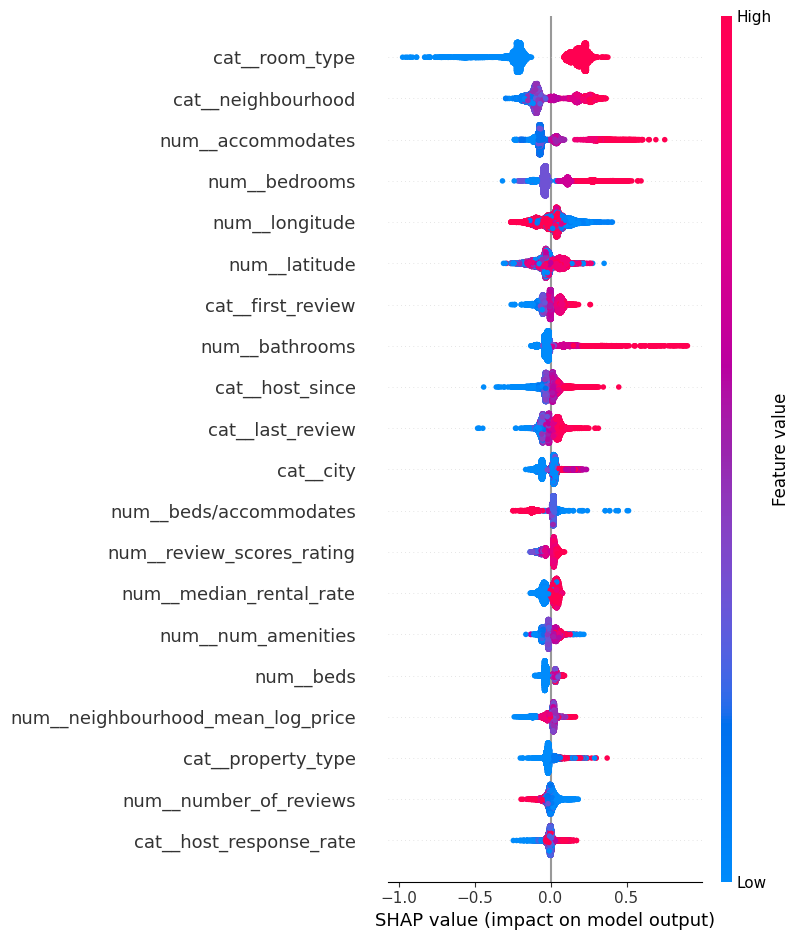

In [40]:
import numpy as np
import shap
from catboost import CatBoostRegressor
from sklearn.metrics import r2_score, mean_squared_error

# CatBoost 모델 학습
model = CatBoostRegressor(iterations=100, verbose=False)
model.fit(processed_X_train, y_train)

# 모델 평가
y_pred = model.predict(processed_X_test)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("R2 Score:", r2)
print("RMSE:", rmse)

# SHAP 값 계산
explainer = shap.Explainer(model)
shap_values = explainer(processed_X_test)

# SHAP 요약 플롯 생성
shap.summary_plot(shap_values, processed_X_test)


xgboost와 비슷한 성능을 보여줍니다. SHAP값의 경우 그래프상 위에 있는 특성이 중요하게 사용되었다는 것이라는데 이에대해서는 추가적인 공부가 필요할 것 같습니다.

catboost로 만든 모델을 추가하여 최종 파이프라인을 만들겠습니다.

In [50]:
model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', CatBoostRegressor(iterations=100, verbose=False))
])
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  Index(['accommodates', 'bathrooms', 'cleaning_fee', 'latitude', 'longitude',
       'number_of_reviews', 'review_scores_rating', 'bedrooms', 'beds',
       'num_amenities', 'median_rental_rate', 'beds/accommodates',
       'bathrooms/accommoda...
                                                                                    SimpleImputer(strategy='most_frequent'))]))]),
                                                  Index(['property_type', 'room_type', 'bed_type', 'cancellation_policy', 'city',
       'first_review', 'host_has_profile_pic', 'host_identity_verified',
       'host_response_rate', 'host_since', 'instant_bookable', 'last_review',
       'neighbourhood'],
      dtype='object'))])),
                ('regressor',
                 <catboost.core.CatBoostRegressor object at 0x7c509aae3cd0>)])

이 모델을 사용하는 예시입니다.

In [63]:
user = X_test[10:11]

In [64]:
user

,property_type,room_type,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,city,first_review,host_has_profile_pic,host_identity_verified,host_response_rate,host_since,instant_bookable,last_review,latitude,longitude,neighbourhood,number_of_reviews,review_scores_rating,bedrooms,beds,num_amenities,median_rental_rate,beds/accommodates,bathrooms/accommodates,neighbourhood_mean_log_price
71413,House,Private room,1,1.0,Real Bed,flexible,False,Boston,2017-03-31,t,t,90%,2014-05-27,f,2017-08-28,42.236793,-71.13133,None,2,100.0,1.0,1.0,15,2700,1.0,1.0,NaN


어떤 user가 자신의 집을 올리고 싶어 합니다.

In [65]:
print(f"적정가격:{np.exp(model.predict(user))}")

적정가격:[119.37162637]


특정 feature를 바꾸면 어떻게 가격이 바뀌는지 관찰합니다.  
이게 잘 작동하면 어떻게 해야 더 높은 가격을 받을 수 있을지 제시해주는 것을 '새로운 시도'롤 해보면 어떨까 생각했었습니다. 하지만 잘 작동하지 않습니다.

In [76]:
userChanged = user.copy()
#accomodates를 1~30까지 바꿔보겠습니다.
for i in range(1,31):
  userChanged['accommodates'] = i
  print(f"accommodates	 : {i} -> 적정가격: {np.exp(model.predict(userChanged))}")

accommodates	 : 1 -> 적정가격: [119.37162637]
accommodates	 : 2 -> 적정가격: [119.37162637]
accommodates	 : 3 -> 적정가격: [119.36471843]
accommodates	 : 4 -> 적정가격: [119.36471843]
accommodates	 : 5 -> 적정가격: [119.36471843]
accommodates	 : 6 -> 적정가격: [119.36471843]
accommodates	 : 7 -> 적정가격: [119.36471843]
accommodates	 : 8 -> 적정가격: [119.36471843]
accommodates	 : 9 -> 적정가격: [119.47508954]
accommodates	 : 10 -> 적정가격: [119.47508954]
accommodates	 : 11 -> 적정가격: [119.47508954]
accommodates	 : 12 -> 적정가격: [119.47508954]
accommodates	 : 13 -> 적정가격: [119.47508954]
accommodates	 : 14 -> 적정가격: [119.47508954]
accommodates	 : 15 -> 적정가격: [119.47508954]
accommodates	 : 16 -> 적정가격: [119.47508954]
accommodates	 : 17 -> 적정가격: [119.47508954]
accommodates	 : 18 -> 적정가격: [119.47508954]
accommodates	 : 19 -> 적정가격: [119.47508954]
accommodates	 : 20 -> 적정가격: [119.47508954]
accommodates	 : 21 -> 적정가격: [119.47508954]
accommodates	 : 22 -> 적정가격: [119.47508954]
accommodates	 : 23 -> 적정가격: [119.47508954]
accommodates	 : 24 -

잘 바뀌지 않는다...